In [1]:
import json
import csv

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math

import sys
sys.path.append("../../")

import implicitmodules.torch as dm

In [2]:

torch.set_default_dtype(torch.float64)

In [3]:
path_datafiles = '/home/gris/Data/2DShapes/'
path_names = path_datafiles + 'NamesPLAINTEXT/'

names = []
with open(path_names + 'labels.txt', 'r') as namelist:
    for line in namelist:
        names.append(line[:-1])

In [4]:
ind_shape = 62

names_subj = []
with open(path_names + 'ShapeNames/' + names[ind_shape] + '.txt', 'r') as namelist:
    for line in namelist:
        names_subj.append(line[:-1])


In [5]:
ind_subj = 0
path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
#subj = 

In [6]:
list_subj = []
list_indi_tri = []
list_majo = []
for ind_subj in range(len(names_subj)):
    path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
    with open(path_subj) as f:
        subj_dict = json.load(f)
        Npts = len(subj_dict['points'])
        subj = []
        for i in range(Npts-1):
            subj.append([subj_dict['points'][i]['x'], subj_dict['points'][i]['y']])

        list_subj.append(np.array(subj))
        
        indi_tri = []
        Ntri = len(subj_dict['triangles'])
        for i in range(Ntri):
            indi_tri.append([subj_dict['triangles'][i]['p1'],subj_dict['triangles'][i]['p2'],subj_dict['triangles'][i]['p3']])
        list_indi_tri.append(np.array(indi_tri))
     
    path_majo = path_datafiles + 'MajorityJSON/Majority/' + names_subj[ind_subj] + '.json'
    with open(path_majo) as f:
        list_majo.append(json.load(f))

(-0.05, 1.05, -0.026747, 0.5616869999999999)

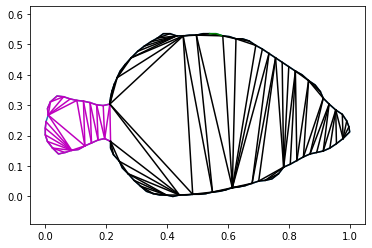

In [7]:
ind_subj = 5
subj = list_subj[ind_subj]
indi_tri = list_indi_tri[ind_subj]
majo_dict = list_majo[ind_subj]

col = ['k', 'm', 'g']
plt.plot(subj[:,0], subj[:,1])
for i in range(np.shape(indi_tri)[0]):
    plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    #plt.gca().add_patch(t1)
plt.axis('equal')

(-0.05, 1.05, -0.026747, 0.5616869999999999)

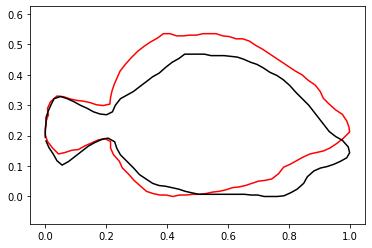

In [53]:
ind_subj_source = 5
subj = list_subj[ind_subj_source]
indi_tri = list_indi_tri[ind_subj_source]
majo_dict = list_majo[ind_subj_source]
plt.plot(subj[:,0], subj[:,1], '-r')

ind_subj_target = 10
subj = list_subj[ind_subj_target]
indi_tri = list_indi_tri[ind_subj_target]
majo_dict = list_majo[ind_subj_target]
plt.plot(subj[:,0], subj[:,1],'k')

plt.axis('equal')

In [22]:
source = torch.tensor(list_subj[ind_subj_source])
target = torch.tensor(list_subj[ind_subj_target])

# Matching with LDDMM

In [1]:
source_deformable = dm.Models.DeformablePoints(source)
target_deformable = dm.Models.DeformablePoints(target)

NameError: name 'dm' is not defined

In [11]:
sigma = 0.05
translations = dm.DeformationModules.ImplicitModule0(2, source.shape[0], sigma, nu=0.1, gd=source.clone().requires_grad_())

In [12]:
sigmas_varifold = [0.1]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

In [51]:
# model = dm.Models.RegistrationModel([source_deformable], [rotation], [dm.Attachment.GeomlossAttachment(loss='sinkhorn', blur=0.05, scaling=0.9)], fit_gd=[True], lam=100.)
model = dm.Models.RegistrationModel([source_deformable], [translations], [attachment], fit_gd=[False], lam=100.)

In [52]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit([target_deformable], 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(114.2584)}
Time: 9.30795827299994
Iteration: 0
Costs
deformation=0.07680685925895461
attach=1.6539690046240008
Total cost=1.7307758638829553
Time: 18.45508797499997
Iteration: 1
Costs
deformation=0.05244530195705441
attach=0.8782762258426002
Total cost=0.9307215277996547
Time: 27.238246774999993
Iteration: 2
Costs
deformation=0.044136771272975855
attach=0.535302860680198
Total cost=0.5794396319531738
Time: 37.126515874999996
Iteration: 3
Costs
deformation=0.0336370119290621
attach=0.2570408880940178
Total cost=0.2906779000230799
Time: 45.75392130600005
Iteration: 4
Costs
deformation=0.03271626571244221
attach=0.18250974746372162
Total cost=0.21522601317616383
Time: 55.060484761
Iteration: 5
Costs
deformation=0.02677213778376907
attach=0.1413457878441493
Total cost=0.16811792562791839
Time: 64.91871213499996
Iteration: 6
Costs
deformation=0.0205260144214356
attach=0.11140823042776749


In [53]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_source = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0]


(-0.05, 1.05, -0.050055064486329216, 1.0511563542129134)

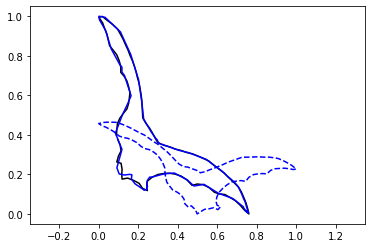

In [54]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(deformed_source.detach().numpy()[:,0], deformed_source.detach().numpy()[:,1], 'b')
plt.axis('equal')

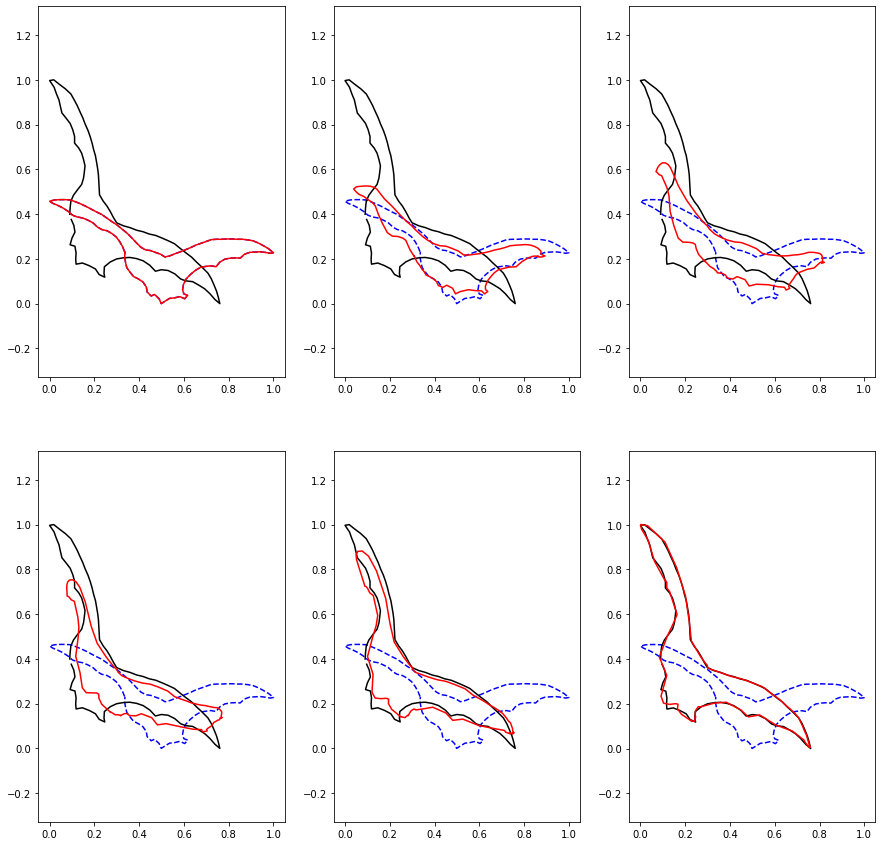

In [56]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
    plt.plot(intermediates['states'][2*i].gd[1].detach().numpy()[:,0], intermediates['states'][2*i].gd[1].detach().numpy()[:,1], 'r')
    plt.axis('equal')

# Matching with growth model

In [23]:
aabb = dm.Utilities.aabb.AABB.build_from_points(source)

In [24]:
aabb.scale_([1.5, 2])

In [25]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=source)


(-0.05, 1.05, -0.026747, 0.5616869999999999)

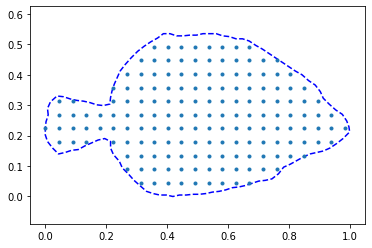

In [26]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.axis('equal')

(-0.05, 1.05, -0.026747, 0.5616869999999999)

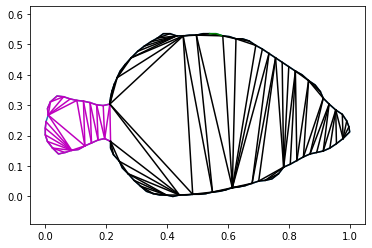

In [27]:
subj = list_subj[ind_subj_source]
indi_tri = list_indi_tri[ind_subj_source]
majo_dict = list_majo[ind_subj_source]

col = ['k', 'm', 'g']
plt.plot(subj[:,0], subj[:,1])
for i in range(np.shape(indi_tri)[0]):
    plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    #plt.gca().add_patch(t1)
plt.axis('equal')

In [28]:
indi_left = range(0, 36)
#indi_left0 = range(0, 28)
#indi_left1 = range(80, 104)
indi_right = range(40, 80)

#part_left = np.concatenate([source[indi_left1, :], source[indi_left0, :]], axis = 0)
part_left = source[indi_left, :]
part_right = source[indi_right, :]

(-0.05, 1.05, -0.026747, 0.5616869999999999)

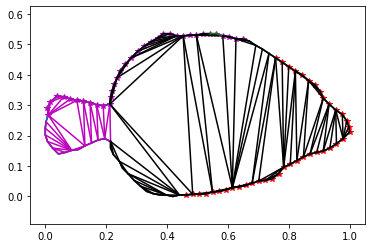

In [29]:
plt.plot(source[:,0], source[:,1], 'k')
plt.plot(part_left[:,0], part_left[:,1], '*m')
plt.plot(part_right[:,0], part_right[:,1], '*r')

col = ['k', 'm', 'g']
plt.plot(subj[:,0], subj[:,1])
for i in range(np.shape(indi_tri)[0]):
    plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    
plt.axis('equal')

In [30]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=source)
points_growthleft = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_left), intersect=True)
points_growthright = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_right), intersect=True)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [31]:
indi_growth_left = range(0,points_growthleft.shape[0] +2)
indi_growth_right = range(points_growth.shape[0]-points_growthright.shape[0], points_growth.shape[0])
indi_growth_main = range(points_growthleft.shape[0] +2,points_growth.shape[0]-points_growthright.shape[0])

(-0.05, 1.05, -0.026747, 0.5616869999999999)

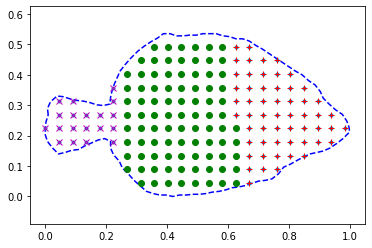

In [32]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.plot(points_growth[indi_growth_left,0], points_growth[indi_growth_left,1], 'xm')
plt.plot(points_growth[indi_growth_right,0], points_growth[indi_growth_right,1], '+r')
plt.plot(points_growth[indi_growth_main,0], points_growth[indi_growth_main,1], 'og')
plt.axis('equal')

In [21]:
#%matplotlib qt5
C = torch.zeros(points_growth.shape[0], 2, 3)
C[indi_growth_left, 0, 0] = 1.
C[indi_growth_right, 0, 1] = 1.
C[indi_growth_main, 0, 2] = 1.
C[indi_growth_main, 1, 2] = 1.

In [33]:
#%matplotlib qt5
C = torch.zeros(points_growth.shape[0], 2, 1)
C[:, 1, 0] = 1.

In [34]:
rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)
#rot_growth[indi_growth_left]= torch.stack([dm.Utilities.rot2d(-0.25*math.pi)])

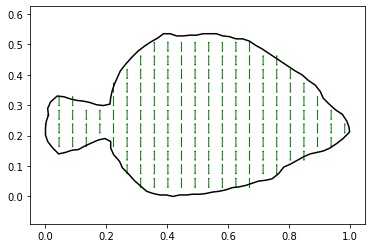

In [35]:
ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, R=rot_growth, c_index=0, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

In [36]:
scale_growth = 0.1
coeff_growth = 1.
nu = 0.001
#growth = dm.DeformationModules.ImplicitModule1(
#    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, coeffcont=100., nu=nu,
#    gd=(points_growth, rot_growth))
growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
    gd=(points_growth, rot_growth))

In [31]:
#%matplotlib qt5
C1 = torch.zeros(points_growth.shape[0], 2, 3)
C1[indi_growth_left, 0, 0] = 1.
C1[indi_growth_right, 0, 1] = 1.
C1[indi_growth_main, 0, 2] = 1.
C1[indi_growth_main, 1, 2] = 1.

In [32]:
points_growth1 = points_growth.clone().detach().requires_grad_()

In [33]:
rot_growth1 = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)

In [34]:
scale_growth1 = 0.2
coeff_growth1 = 1.
nu1 = 0.001
#growth = dm.DeformationModules.ImplicitModule1(
#    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, coeffcont=100., nu=nu,
#    gd=(points_growth, rot_growth))
growth1 = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth1, C1, coeff=coeff_growth1, nu=nu1,
    gd=(points_growth1, rot_growth1))

In [39]:
rotation = dm.DeformationModules.LocalRotation(2, 2., gd=torch.tensor([[0., 0.]]).requires_grad_())

In [37]:
global_translation = dm.DeformationModules.GlobalTranslation(2)

In [40]:
source_deformable = dm.Models.DeformablePoints(source)
target_deformable = dm.Models.DeformablePoints(target)

In [41]:
sigmas_varifold = [0.1, 1.]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

In [42]:

def rot2d_vec(thetas):
    assert len(thetas.shape) == 1
    sin = torch.sin(thetas)
    cos = torch.cos(thetas)

    return torch.stack([torch.stack([cos, -sin], dim=1),
                        torch.stack([sin, cos], dim=1)], dim=2)


In [43]:
def precompute(init_manifold, modules, parameters):
    basis = rot2d_vec(parameters['angles']['params'][0][:, 0])
    init_manifold[3].gd = (init_manifold[3].gd[0], basis)

    #basis = rot2d_vec(parameters['angles']['params'][1][:, 0])
    #init_manifold[4].gd = (init_manifold[4].gd[0], basis)

angles = torch.zeros(points_growth.shape[0], 1, requires_grad=True)
#angles1 = torch.zeros(points_growth.shape[0], 1, requires_grad=True)

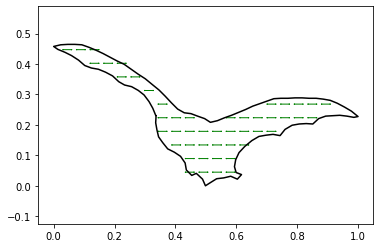

In [41]:
rot_g = rot2d_vec(angles[:,0])
ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, R=rot_g.detach(), c_index=0, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

In [44]:
#modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, rotation, growth], [attachment], fit_gd=[False], lam=10.)
modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, rotation, growth], [attachment], fit_gd=[False], lam=10.,precompute_callback=precompute, other_parameters={'angles': {'params': [angles]}})

In [45]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(modelgrowth, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit([target_deformable], 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(3.0570)}
Time: 171.59309101399958
Iteration: 0
Costs
deformation=0.0042913394052157185
attach=0.21795842402016374
Total cost=0.22224976342537947
Time: 354.96724888899917
Iteration: 1
Costs
deformation=0.0006610403624248044
attach=0.2072226276004252
Total cost=0.20788366796285002
Time: 518.9021639900002
Iteration: 2
Costs
deformation=0.0035962541376216212
attach=0.19434463969055127
Total cost=0.1979408938281729
Time: 715.3938576789988
Iteration: 3
Costs
deformation=0.003739251138758743
attach=0.17337063970255917
Total cost=0.17710989084131792
Time: 881.008520243
Iteration: 4
Costs
deformation=1.7720779870973802e-05
attach=0.1595285408400171
Total cost=0.15954626161988808
Time: 1065.103121487
Iteration: 5
Costs
deformation=0.0003431676382462579
attach=0.1539407562576578
Total cost=0.15428392389590406
Time: 1248.2411129020002
Iteration: 6
Costs
deformation=6.688405650572984e-05
attach=0

In [46]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_source = modelgrowth.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0]


(-0.05, 1.05, -0.0286671460991114, 0.5617784355285291)

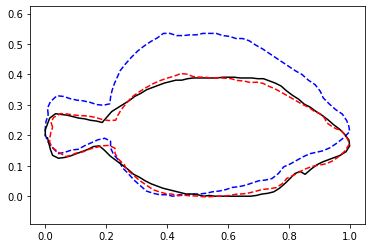

In [47]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(deformed_source.detach().numpy()[:,0], deformed_source.detach().numpy()[:,1], '--r')
plt.axis('equal')

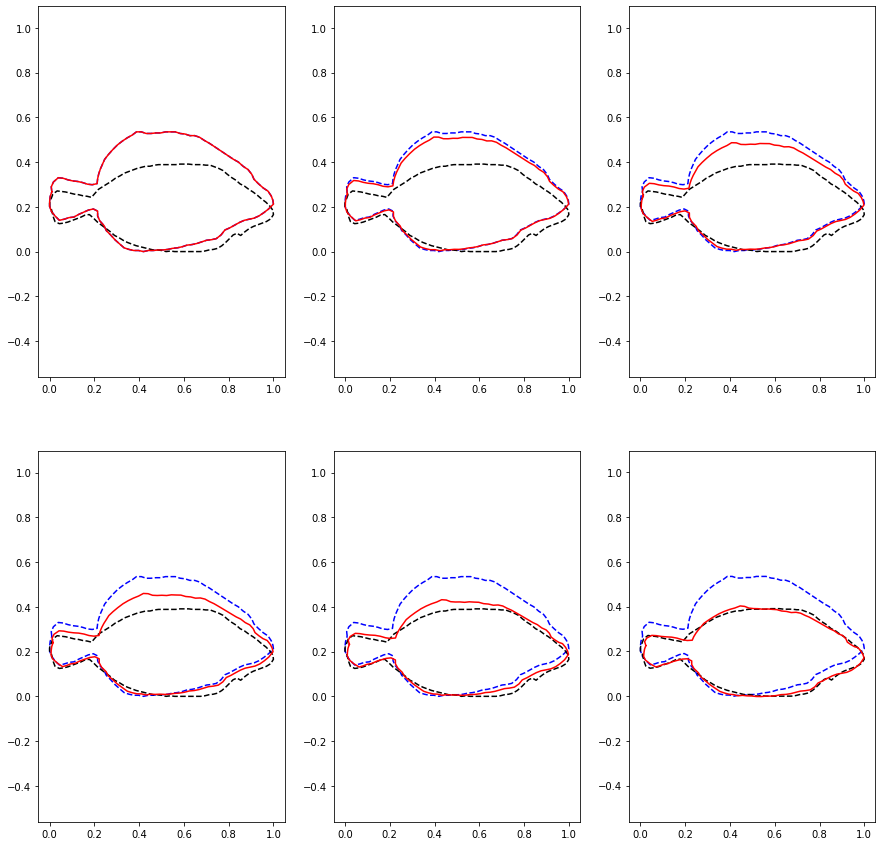

In [48]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    #if i<5:
    #    #print(intermediates['controls'][2*i][3])
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates['states'][2*i].gd[0].detach().numpy()[:,0], intermediates['states'][2*i].gd[0].detach().numpy()[:,1], 'r')
    plt.axis('equal')

In [49]:
for i in range(11):
    print(intermediates['controls'][i][4])

tensor([ 0.0355, -0.0077, -0.0259])
tensor([ 0.0350, -0.0077, -0.0260])
tensor([ 0.0345, -0.0078, -0.0263])
tensor([ 0.0339, -0.0080, -0.0267])
tensor([ 0.0333, -0.0083, -0.0271])
tensor([ 0.0326, -0.0087, -0.0276])
tensor([ 0.0320, -0.0093, -0.0282])
tensor([ 0.0315, -0.0103, -0.0289])
tensor([ 0.0313, -0.0118, -0.0298])
tensor([ 0.0314, -0.0145, -0.0309])


IndexError: list index out of range

In [50]:
angles[:,0] - angles1[:,0]

tensor([ 1.8966, -1.8282, -1.5256, -1.7812, -1.3787, -1.6296,  0.1160, -0.0512,
        -0.1268, -2.2729, -0.5666, -1.2072, -0.2687, -0.2582, -0.2930, -0.0691,
        -0.0266, -0.0046,  0.0106, -0.1002,  0.4377,  0.3407,  0.2931,  0.2214,
         0.8229,  0.7288,  0.5752,  0.3620,  1.1392,  1.0311,  0.7975,  0.7663,
        -0.4997,  0.3745,  0.8311,  0.3363,  0.2039,  0.5009,  0.1991,  0.1635,
        -0.0751,  0.0390, -1.6064,  1.0900,  0.3159, -0.4439,  0.1277, -0.4931],
       grad_fn=<SubBackward0>)

In [51]:
rot_opt = rot2d_vec(angles1[:,0])

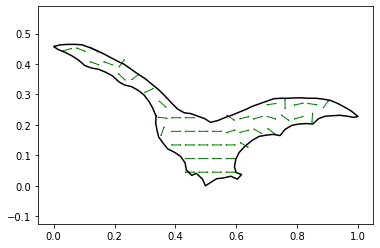

In [52]:


ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, R=rot_opt.detach(), c_index=0, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

In [133]:
sum([intermediates['controls'][i][3] for i in range(10)])

tensor([-1.4724, -0.9232, -0.8754])

In [134]:
for i in range(10):
    print(intermediates['controls'][i][3])

tensor([-0.1470, -0.0912, -0.0962])
tensor([-0.1509, -0.0921, -0.0954])
tensor([-0.1545, -0.0929, -0.0945])
tensor([-0.1570, -0.0937, -0.0931])
tensor([-0.1578, -0.0942, -0.0912])
tensor([-0.1559, -0.0943, -0.0887])
tensor([-0.1510, -0.0937, -0.0855])
tensor([-0.1431, -0.0925, -0.0816])
tensor([-0.1331, -0.0906, -0.0771])
tensor([-0.1221, -0.0881, -0.0722])


In [135]:
# We extract the modules of the models and fill the right manifolds.
silent = dm.DeformationModules.SilentBase(copy.copy(modelgrowth.init_manifold.clone().manifolds[0]), label='sil')
modules = dm.DeformationModules.CompoundModule(copy.copy(modelgrowth.modules))
modules.manifold.fill(modelgrowth.init_manifold.clone(), copy=True)
deformation_grid = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
#translation = copy.copy(modelgrowth.modules[0])
#growth2 = copy.copy(modelgrowth.modules[1])

In [136]:
CompoundModule = dm.DeformationModules.CompoundModule([deformation_grid] + modules.modules)

In [137]:
# We construct the controls list we will give will shooting
controls = [[torch.tensor([]), torch.tensor([]), 0.*control[1], 0.*control[2], torch.tensor([0.*control[3][0], 1.*control[3][1], 0.*control[3][2]])] for control in intermediates['controls']]

In [138]:
intermediates_cont = {}
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(CompoundModule.modules), shoot_solver, shoot_it, controls=controls, intermediates=intermediates_cont)

In [139]:
growth_deformed_source = silent.manifold.gd.detach()
growth_deformed_grid = deformation_grid.togrid()

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


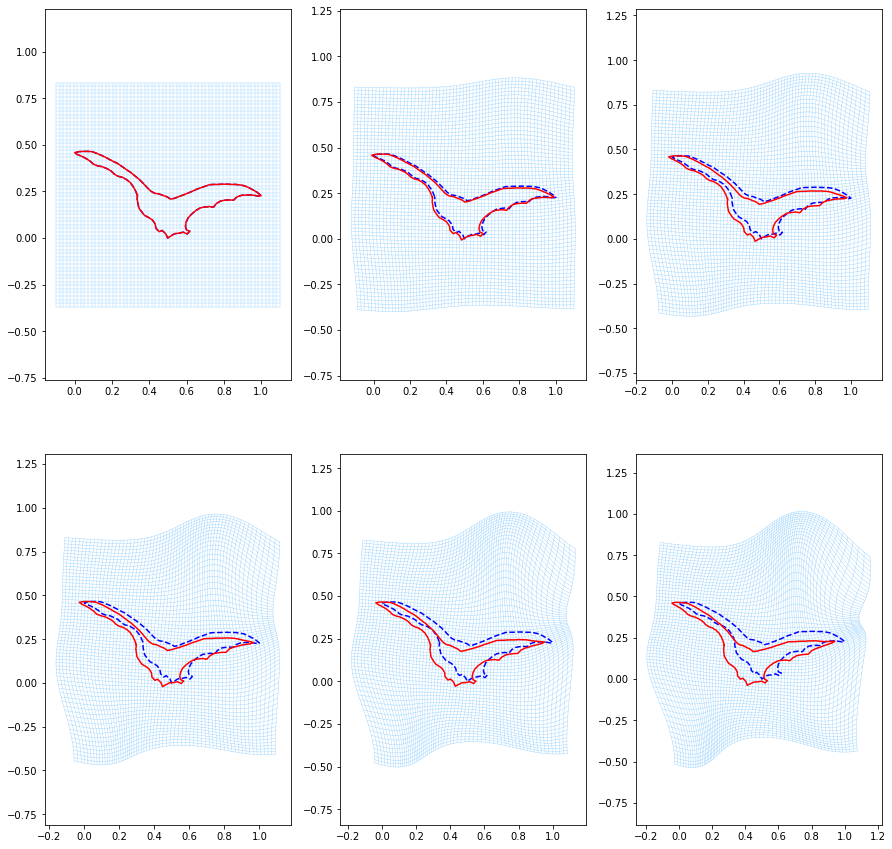

In [140]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    if i<5:
        print(intermediates_cont['controls'][2*i][3])
    deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
    deformation_grid_t.manifold.fill_gd(intermediates_cont['states'][2*i].gd[0].detach())
    growth_deformed_grid_t = deformation_grid_t.togrid()
    dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    #plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,0], intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,1], 'r')
    plt.axis('equal')

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(-0.)


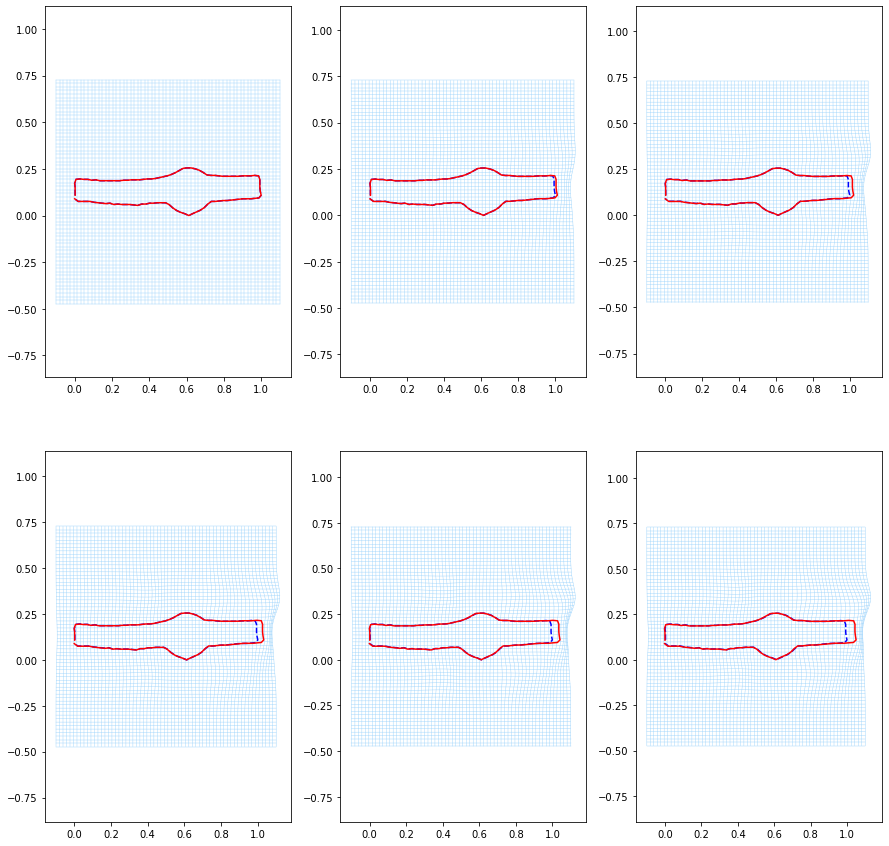

In [81]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    if i<5:
        print(intermediates_cont['controls'][2*i][3])
    deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
    deformation_grid_t.manifold.fill_gd(intermediates_cont['states'][2*i].gd[0].detach())
    growth_deformed_grid_t = deformation_grid_t.togrid()
    dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    #plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,0], intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,1], 'r')
    plt.axis('equal')

(-0.2099575578392855,
 1.3644548670464338,
 -0.5323633347340097,
 0.7877051311809289)

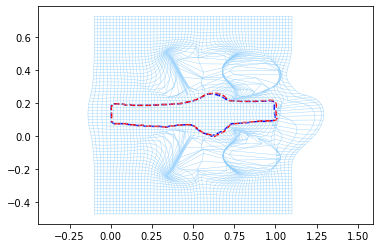

In [75]:
#%matplotlib qt5
ax = plt.subplot(1, 1, 1)
plt.plot(source.detach().numpy()[:, 0], source.detach().numpy()[:, 1], '--b')
#plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(growth_deformed_source[:, 0].numpy(), growth_deformed_source[:, 1].numpy(), '--r')
dm.Utilities.plot_grid(ax, growth_deformed_grid[0], growth_deformed_grid[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')


# Working on images

In [11]:
source_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/watch01.png', origin='lower')
target_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/watch03.png', origin='lower')

In [34]:
source_image.shape

torch.Size([202, 500])

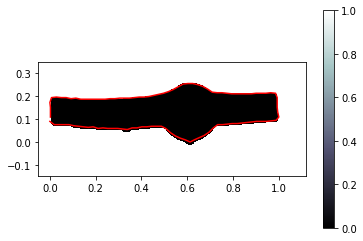

In [12]:

extent_source = dm.Utilities.AABB( -0.05, 1.12,-0.15, 0.35)

plt.imshow(source_image.numpy(), origin='lower', cmap='bone', extent=extent_source.totuple())
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], 'r')
plt.colorbar()

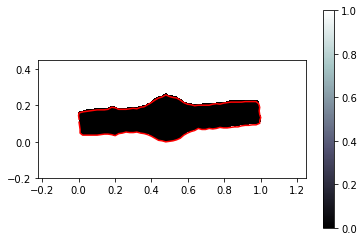

In [13]:
extent_target = dm.Utilities.AABB( -0.22, 1.25,-0.2, 0.45)
target_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/watch11.png', origin='lower')
plt.imshow(target_image.numpy(), origin='lower', cmap='bone', extent=extent_target.totuple())
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'r')
plt.colorbar()

In [14]:
indi_left0 = range(0, 28)
indi_left1 = range(80, 104)
indi_right = range(37, 69)

part_left = np.concatenate([source[indi_left1, :], source[indi_left0, :]], axis = 0)
part_right = source[indi_right, :]

In [15]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=source)
points_growthleft = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_left), intersect=True)
points_growthright = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_right), intersect=True)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [16]:
indi_growth_left = range(0,points_growthleft.shape[0] +2)
indi_growth_right = range(points_growth.shape[0]-points_growthright.shape[0], points_growth.shape[0])

(-0.05, 1.05, -0.012766, 0.268086)

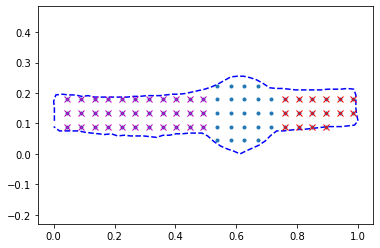

In [17]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.plot(points_growth[indi_growth_left,0], points_growth[indi_growth_left,1], 'xm')
plt.plot(points_growth[indi_growth_right,0], points_growth[indi_growth_right,1], 'xr')
plt.axis('equal')

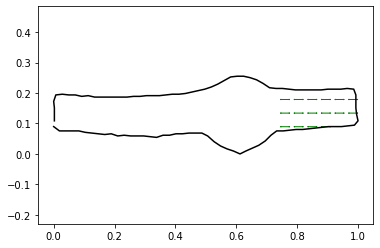

In [18]:
#%matplotlib qt5
C = torch.zeros(points_growth.shape[0], 2, 2)
C[indi_growth_left, 0, 0] = 1.
C[indi_growth_right, 0, 1] = 1.

ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, c_index=1, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()


In [19]:
rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)
scale_growth = 0.1
coeff_growth = 1.
nu = 0.001
growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
    gd=(points_growth, rot_growth))

In [20]:
global_translation = dm.DeformationModules.GlobalTranslation(2)

In [21]:
source_deformable = dm.Models.DeformableImage(source_image, output='bitmap',
                                              extent=extent_source)
target_deformable = dm.Models.DeformableImage(target_image, output='bitmap',
                                              extent=extent_target)

In [22]:

source_image_deformable = dm.Models.DeformableImage(source_image, output='bitmap',
                                              extent=extent_source)
target_image_deformable = dm.Models.DeformableImage(target_image, output='bitmap',
                                              extent=extent_target)


In [23]:
attachment_image = dm.Attachment.EuclideanPointwiseDistanceAttachment()

In [31]:
target_image_deformable.geometry[0].shape

torch.Size([224, 520])

In [30]:
source_image_deformable.geometry[0].shape

torch.Size([202, 500])

In [26]:
attachment_image(source_image_deformable.geometry, target_image_deformable.geometry)

RuntimeError: The size of tensor a (500) must match the size of tensor b (520) at non-singleton dimension 1

In [81]:
modelgrowth_image = dm.Models.RegistrationModel([source_image_deformable], [global_translation, growth], [attachment_image], fit_gd=[False], lam=100.)

In [83]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(modelgrowth_image, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit(target_image_deformable, 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

KeyboardInterrupt: 